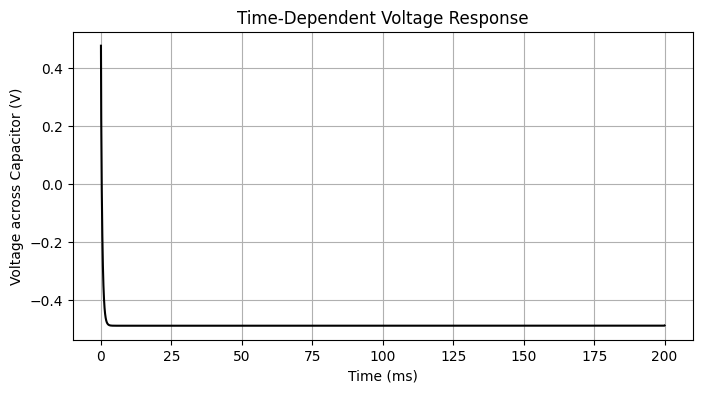

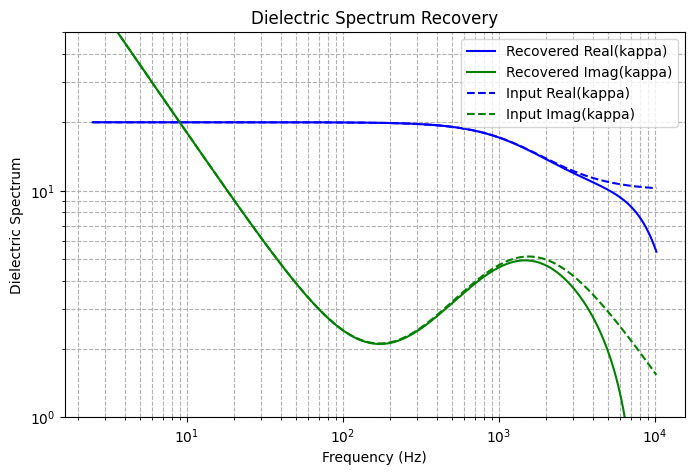

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.constants as scc
import matplotlib.pyplot as plt
from transform_dielectric_data import V_debye_sim, get_kappa, sim_kappa

# Example: Simulate data using a single-time-constant Debye model and attempt recovery

# Physical Setup:
# RC voltage divider circuit, resistor (R) on top, capacitor (C) below filled with dielectric.
# Driven by a square wave voltage, measuring voltage across capacitor.

# Time series parameters
N = 2**13
T = 200 * scc.milli  # period of half square wave in seconds
t = np.linspace(0, T, N // 2)  # time array, half-period

# Dielectric simulation parameters
C0 = 21.94 * scc.pico   # capacitance of empty capacitor
R = 1 * scc.mega      # resistance of resistor
rho = 1e15             # resistivity of dielectric medium
k0 = 10               # high-frequency dielectric constant (W = infinity)
Delta_k = 10          # amplitude of time-dependent dielectric constant
tau = 1e-4            # Debye relaxation time

# Simulate voltage response
Vt = V_debye_sim(t, R, C0, k0, Delta_k, tau, rho)

# Plot simulated voltage response
plt.figure(figsize=(8, 4))
plt.plot(t / scc.milli, Vt, '-k')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage across Capacitor (V)')
plt.title('Time-Dependent Voltage Response')
plt.grid(True)

# Recover dielectric constant from voltage data
W, kappa = get_kappa(t, Vt, R * C0)
ksim = sim_kappa(W, k0, Delta_k, tau, rho)

# Plot recovered vs. simulated dielectric spectrum
plt.figure(figsize=(8, 5))
plt.plot(W / (2 * np.pi), np.real(kappa), '-b', label='Recovered Real(kappa)')
plt.plot(W / (2 * np.pi), -np.imag(kappa), '-g', label='Recovered Imag(kappa)')
plt.plot(W / (2 * np.pi), np.real(ksim), '--b', label='Input Real(kappa)')
plt.plot(W / (2 * np.pi), -np.imag(ksim), '--g', label='Input Imag(kappa)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dielectric Spectrum')
plt.title('Dielectric Spectrum Recovery')
plt.legend()
plt.ylim(1, 50)
plt.grid(True, which='both', ls='--')

plt.show()

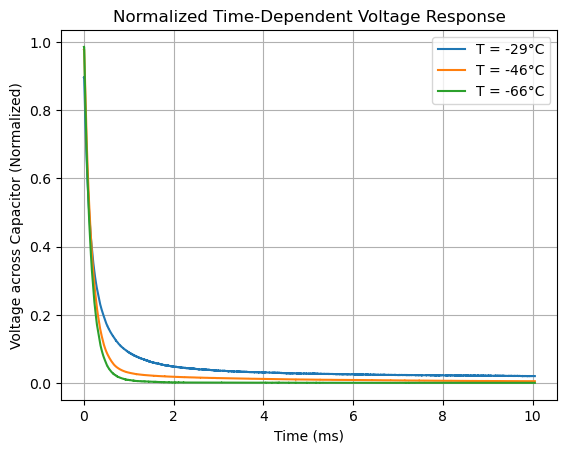

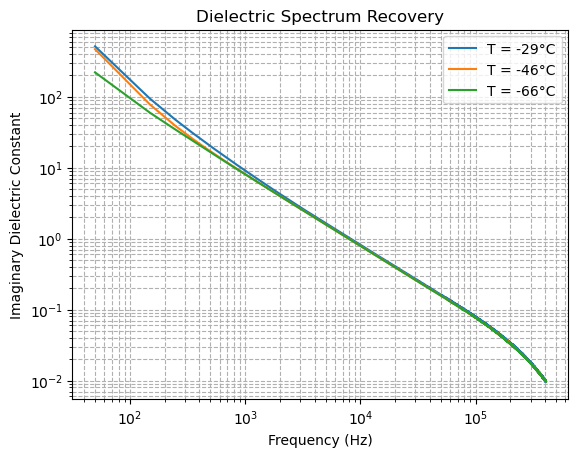

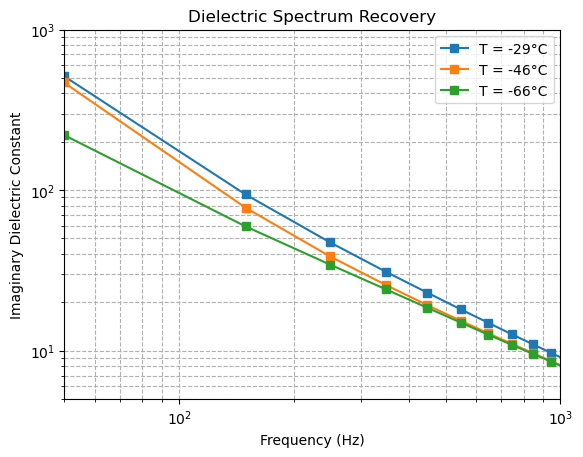

In [ ]:
import json
import numpy as np
import scipy.constants as scc
import matplotlib.pyplot as plt

def load_and_preprocess_data(filepath, dataset_name, V0=3.25):
    """
    Load dataset from JSON file and preprocess it.

    Parameters:
        filepath (str): Path to the JSON data file.
        dataset_name (str): Name of the dataset to load.
        V0 (float): Normalization voltage value.

    Returns:
        tuple: (time array (s), normalized voltage, temperature (°C))
    """
    with open(filepath, "r") as f:
        loaded_data = json.load(f)
        ds = loaded_data['datasets'][dataset_name]
    temperature = ds["temperature"]
    t_exp = np.array(ds["x"]) * scc.micro
    v_exp = np.array(ds["y"]) / V0
    return t_exp, v_exp, temperature

# Configuration Parameters
data_file = "Data/merged_data.json"
V0 = 3.25
R = 1 * scc.mega
C0 = 22 * scc.pico
RC = R * C0

# Datasets to process
datalist = ['dataset_9', 'dataset_12', 'dataset_16']

# Initialize figures only once, outside the loop
fig_time, ax_time = plt.subplots()
fig_spec, ax_spec = plt.subplots()
fig_spec_fine, ax_spec_fine = plt.subplots()

# Loop over datasets, process and plot
for dataname in datalist:
    # Load and preprocess data
    t_exp, v_exp, temperature = load_and_preprocess_data(data_file, dataname, V0=V0)

    # Plot normalized time-dependent voltage response
    ax_time.plot(t_exp / scc.milli, v_exp, label=f'T = {temperature:.0f}°C')

    # Recover dielectric constant from voltage data
    W, kappa = get_kappa(t_exp, v_exp, RC)

    # Plot dielectric spectrum
    ax_spec.plot(W / (2 * np.pi), np.imag(kappa), label=f'T = {temperature:.0f}°C')
    ax_spec_fine.plot(W / (2 * np.pi), np.imag(kappa),marker='s', label=f'T = {temperature:.0f}°C')

# Customize Time Response Plot
ax_time.set_xlabel('Time (ms)')
ax_time.set_ylabel('Voltage across Capacitor (Normalized)')
ax_time.set_title('Normalized Time-Dependent Voltage Response')
ax_time.grid(True)
ax_time.legend()

# Customize Dielectric Spectrum Plot
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
ax_spec.set_xlabel('Frequency (Hz)')
ax_spec.set_ylabel('Imaginary Dielectric Constant')
ax_spec.set_title('Dielectric Spectrum Recovery')
ax_spec.grid(True, which='both', linestyle='--')
ax_spec.legend()

# Customize Dielectric Spectrum Plot fine scale
ax_spec_fine.set_xscale('log')
ax_spec_fine.set_yscale('log')
ax_spec_fine.set_xlim(50,1000)
ax_spec_fine.set_ylim(5,1000)
ax_spec_fine.set_xlabel('Frequency (Hz)')
ax_spec_fine.set_ylabel('Imaginary Dielectric Constant')
ax_spec_fine.set_title('Dielectric Spectrum Recovery')
ax_spec_fine.grid(True, which='both', linestyle='--')
ax_spec_fine.legend()

plt.show()


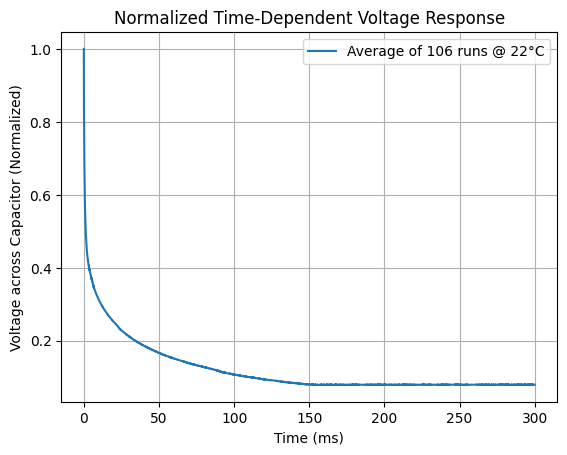

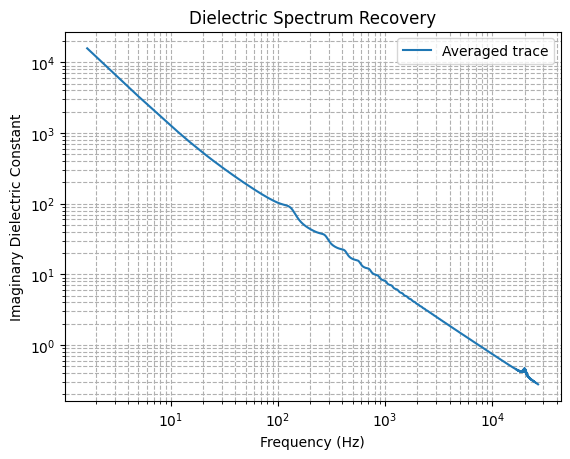

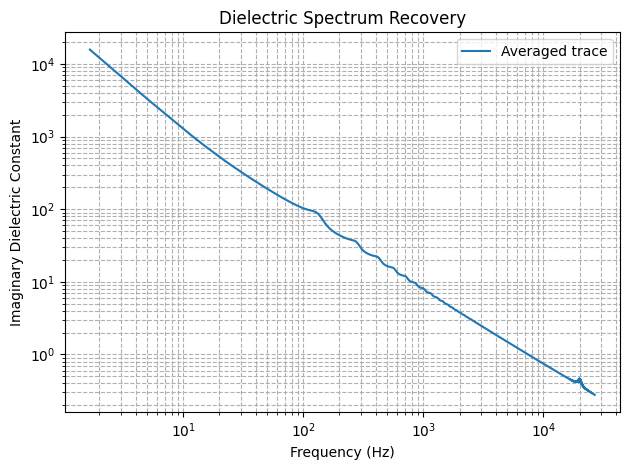

In [7]:
import zipfile, struct, numpy as np
import scipy.constants as scc
import matplotlib.pyplot as plt
from transform_dielectric_data import get_kappa

# ====== CONFIG ======
ZIP_PATH = r"C:\Users\klipk\Downloads\Glycerol.zip"
R  = 1 * scc.mega          # series resistor (Ohm)
C0 = 22 * scc.pico         # empty-cell capacitance (F)
RC = R * C0

# Teensy framing (must match your sketch)
S_HIGH  = 50
S_LOW   = 16000
BYTES_H   = S_HIGH * 2      # uint16_t * 50
BYTES_TH  = 4               # unsigned long
BYTES_L   = S_LOW * 2       # uint16_t * 16000
BYTES_TL1 = 4               # unsigned long
BYTES_TL2 = 4               # unsigned long
BYTES_AG  = 4               # float
TOTAL     = BYTES_H + BYTES_TH + BYTES_L + BYTES_TL1 + BYTES_TL2 + BYTES_AG  # 32116

V_REF      = 3.3
ADC_MAX_10 = 1023.0
ADC_MAX_12 = 4095.0

def parse_teensy_record(raw):
    """Return (t_s, v_norm, temp_C) from one Teensy binary record."""
    idx = 0
    vh = np.frombuffer(raw[idx:idx+BYTES_H], dtype=np.uint16); idx += BYTES_H
    t_high = struct.unpack('<I', raw[idx:idx+BYTES_TH])[0]; idx += BYTES_TH
    vl = np.frombuffer(raw[idx:idx+BYTES_L], dtype=np.uint16); idx += BYTES_L
    totalLow1 = struct.unpack('<I', raw[idx:idx+BYTES_TL1])[0]; idx += BYTES_TL1
    totalLow  = struct.unpack('<I', raw[idx:idx+BYTES_TL2])[0]; idx += BYTES_TL2
    avg_ct    = struct.unpack('<f', raw[idx:idx+BYTES_AG])[0];  idx += BYTES_AG

    # --- Time axes (µs) ---
    dt_high = t_high / float(S_HIGH)
    dt_low1 = totalLow1 / 1200.0
    rem = S_LOW - 1200
    dt_low2 = (totalLow - totalLow1) / float(rem) if rem > 0 else 0.0

    th_ax  = np.arange(S_HIGH, dtype=float) * dt_high
    tl_ax1 = (th_ax[-1] + dt_high) + np.arange(1200, dtype=float) * dt_low1
    tl_ax2 = (tl_ax1[-1] + dt_low1) + np.arange(rem, dtype=float) * dt_low2
    t_us   = np.concatenate([th_ax, tl_ax1, tl_ax2])
    t_s    = t_us * 1e-6

    # --- Voltages ---
    v_high = vh * (V_REF / ADC_MAX_10)
    v_low1 = vl[:1200] * (V_REF / ADC_MAX_12)
    v_low2 = vl[1200:] * (V_REF / ADC_MAX_12)
    v      = np.concatenate([v_high, v_low1, v_low2])

    # Normalize by initial voltage
    v0 = v[0] if v[0] > 0 else np.max(v)
    v_norm = v / v0

    # (Optional) quick PT1000 temp for labeling
    v_th = (avg_ct / ADC_MAX_10) * V_REF
    R_REF = 1000.0
    if V_REF - v_th <= 0:
        temp_C = float('nan')
    else:
        R_th = R_REF * v_th / (V_REF - v_th)
        T_ref = np.array([-79, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30], dtype=float)
        R_ref = np.array([687.30, 723.30, 763.30, 803.10, 842.70, 882.20, 921.60, 960.90,
                          1000.00, 1039.00, 1077.90, 1116.70], dtype=float)
        temp_C = float(np.interp(R_th, R_ref, T_ref))

    return t_s, v_norm, temp_C

# ---------- Read ZIP, average all traces on a common grid ----------
t_grid = None
sum_v  = None
count  = 0
temps  = []

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    for info in zf.infolist():
        if info.is_dir() or info.file_size != TOTAL:
            continue
        try:
            raw = zf.read(info)
            t_s, v_norm, temp_C = parse_teensy_record(raw)

            if t_grid is None:
                t_grid = t_s.copy()
                sum_v  = np.zeros_like(t_grid, dtype=float)

            # Interpolate each trace onto the first file's grid
            v_interp = np.interp(t_grid, t_s, v_norm)
            sum_v += v_interp
            count += 1
            if np.isfinite(temp_C):
                temps.append(temp_C)
        except Exception as e:
            print(f"Skipped {info.filename}: {e}")

if count == 0:
    raise RuntimeError("No valid records found to average.")
v_avg = sum_v / count

# ============ SAME THREE GRAPHS AS YOUR JSON SCRIPT ============

# 1) Normalized Time-Dependent Voltage Response
fig_time, ax_time = plt.subplots()
ax_time.plot(t_grid / scc.milli, v_avg,
             label=(f'Average of {count} runs'
                    + (f' @ {np.mean(temps):.0f}°C' if temps else '')))
ax_time.set_xlabel('Time (ms)')
ax_time.set_ylabel('Voltage across Capacitor (Normalized)')
ax_time.set_title('Normalized Time-Dependent Voltage Response')
ax_time.grid(True)
ax_time.legend()

# 2) Dielectric Spectrum Recovery (full)
W, kappa = get_kappa(t_grid, v_avg, RC)
f = W / (2*np.pi)

fig_spec, ax_spec = plt.subplots()
ax_spec.plot(f, np.imag(kappa), label='Averaged trace')
ax_spec.set_xscale('log')
ax_spec.set_yscale('log')
ax_spec.set_xlabel('Frequency (Hz)')
ax_spec.set_ylabel('Imaginary Dielectric Constant')
ax_spec.set_title('Dielectric Spectrum Recovery')
ax_spec.grid(True, which='both', linestyle='--')
ax_spec.legend()

# 3) Dielectric Spectrum Recovery (fine/zoomed)
fig_spec_fine, ax_spec_fine = plt.subplots()
ax_spec_fine.plot(f, np.imag(kappa), label='Averaged trace')
ax_spec_fine.set_xscale('log')
ax_spec_fine.set_yscale('log')
ax_spec_fine.set_xlabel('Frequency (Hz)')
ax_spec_fine.set_ylabel('Imaginary Dielectric Constant')
ax_spec_fine.set_title('Dielectric Spectrum Recovery')
ax_spec_fine.grid(True, which='both', linestyle='--')
ax_spec_fine.legend()

plt.tight_layout()
plt.show()
